# ML Project

## Setup

## Install Packages

In [1]:
%%capture
pip install pandas numpy matplotlib tensorflow tensorflow-addons tqdm bs4 IP2Location chardet scikit-learn ipywidgets widgetsnbextension mlxtend

In [2]:
%%capture
!conda install -c conda-forge -y ipywidgets
!conda install -c conda-forge -y tqdm
!jupyter nbextension enable --py widgetsnbextension

### Import Modules

In [3]:
import requests
import urllib3
from urllib.parse import urlparse, urljoin
import socket

from bs4 import BeautifulSoup
import chardet
import re
import json
import ast


import math
import statistics
from matplotlib import pyplot

import os
import IP2Location

import pandas as pd
import numpy as np

import random
import itertools

from tqdm.notebook import tqdm
from IPython.display import display

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
print(tf.__version__)
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix

from mlxtend.plotting import plot_confusion_matrix

#from tensorflow.python.ops.numpy_ops import np_config
#np_config.enable_numpy_behavior()

import warnings
warnings.filterwarnings(action="ignore", module="urllib3")
warnings.filterwarnings(action="ignore", module="tensorflow_addons")
warnings.filterwarnings(action="ignore", module="tensorflow")
warnings.filterwarnings(action="ignore", module="matplotlib")
warnings.filterwarnings(action="ignore", module="sklearn")

2.12.0


/home/benjamin/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Download More Data / Feature Engineering

### Set Constants

In [4]:
DOWNLOAD_CHUNK_SIZE = 100
TIMEOUT = (10, 10)
feature_names = ["words", "aux", "city", "region", "country", "redirects", "latitude", "longitude"]

### Define Helper Functions

In [5]:
ip2location_database = IP2Location.IP2Location()
ip2location_database.open(os.path.join("location_data", "IP2LOCATION-LITE-DB11.BIN"))
def get_location(ip_addr=None, hostname=None):
    if(ip_addr is None and hostname is not None):
        try:
            ip_addr = socket.gethostbyname(hostname)
        except socket.gaierror:
            print("Skipped Location Download (Hostname Resolution Error for '"+hostname+"')")
            return None
    location_data = ip2location_database.get_all(ip_addr)
    if(location_data.country_short == "-"):
        if(not ip_addr in location_database):
            location_data = requests.get("https://ipinfo.io/"+ip_addr+"/json").json()
            if("error" in location_data):
                raise Exception("Failed because error with download (probably api quota exceded)")
            location_database[ip_addr] = location_data
            location_database[ip_addr]["country_short"] = location_data["country"]
            location_database[ip_addr]["latitude"], location_database[ip_addr]["longitude"] = tuple(location_data["loc"].split(","))
    else:
        return ast.literal_eval(str(location_data))
    return location_database[ip_addr]

In [6]:
def get_absolute_url_from_relative(original_url, new_url):
    if(new_url.startswith("javascript")):
        return None
    if(new_url.startswith("http")):
        return new_url
    url_with_scheme = "http://"+original_url if not original_url.startswith("http") else original_url
    parsed_url = urlparse(url_with_scheme)
    url_scheme = parsed_url.scheme
    url_host = parsed_url.netloc
    
    return urljoin(url_scheme+"://"+url_host, new_url)

In [7]:
def download_aux_data(content, original_url):
    aux = []
    soup = BeautifulSoup(content, 'html.parser')
    for a in soup.find_all('a'):
        href = a.get('href')
        if(href is not None):
            url = get_absolute_url_from_relative(original_url, href)
            if(url is not None):
                hostname = urlparse(url).netloc
                json = get_location(hostname=hostname)
                if(json is None):
                    continue
                try:
                    columns = [
                        "hostname_"+hostname,
                        "ip_addr_"+json["ip"],
                        "latitude_"+str(int(float(json["latitude"]))),
                        "longitude_"+str(int(float(json["longitude"]))),
                        "city_"+json["city"],
                        "region_"+json["region"],
                        "country_"+json["country_short"],
                    ]
                except KeyError:
                    if("bogon" in json and json["bogon"]):
                        print("Skipped Aux Data Download (Bogon IP)")
                    else:
                        print("Problem with JSON: ", json)
                    columns = []
                
                columns = [ re.compile('[\W_]+').sub('_', column) for column in columns ]
                
                aux = aux + columns
                
    return " ".join(aux)

In [8]:
def download_one(original_url, timeout=TIMEOUT):
    row = {}
    row["attempted_download"] = True

    url_with_scheme = "http://"+original_url if not original_url.startswith("http") else original_url
    parsed_url = urlparse(url_with_scheme)
    hostname = parsed_url.netloc
    
    try:
        row["hostname"] = hostname
        
        ip_addr = socket.gethostbyname(hostname)
        row["ip_addr"] = ip_addr

        r = requests.get(url_with_scheme, verify=False, timeout=timeout)

        row["status_code"] = r.status_code
        encoding = chardet.detect(r.content)['encoding']
        #if(encoding == None):
        #    print("Skipped content download (Decoding Error)")
        try:
            content = r.content.decode(encoding)
            row["content"] = content
        except:
            try:
                content = r.content.decode("utf")
            except:
                content = None
                print("Skipped Content Download (Decoding Error)")
            
        if(content is not None):
            row["aux"] = download_aux_data(content, original_url)
            row["words"] = " ".join(re.compile('[\W_]+').sub(' ', BeautifulSoup(content, 'html.parser').get_text()).split(" "))
        
        redirects = 0
        for r_history in r.history:
            if(r_history.status_code == 301):
                redirects = redirects + 1
        row["redirects"] = redirects

        json = get_location(ip_addr=ip_addr)
        if(json is None):
            return row
        try:
            row["latitude"] = json["latitude"]
            row["longitude"] = json["longitude"]
            row["city"] = json["city"]
            row["region"] = json["region"]
            row["country"] = json["country_short"]

        except KeyError:
            if("bogon" in json and json["bogon"]):
                print("Skipped Location Download (Bogon IP)")
            else:
                print("Problem with JSON: ", json)
        
    except socket.gaierror:
        print("Skipped (Hostname Resolution Error for '"+hostname+"')")
                      
    except socket.error:
        print("Skipped (Content Download Error for '"+url_with_scheme+"')")
        
    except UnicodeError:
        print("Skipped (Unicode Error for '"+url_with_scheme+"')")
    
    return row

In [9]:
def download_chunk(chunk_size=DOWNLOAD_CHUNK_SIZE, timeout=TIMEOUT):
    global raw_data
    if(len(raw_data[raw_data["attempted_download"] == True].index) != 0):
          start = raw_data[raw_data["attempted_download"] == True].index[-1]+1
    end = start + chunk_size
    end = end if len(raw_data["url"]) > end else len(raw_data["url"])
    
    print("Downloading %d more rows ([%d:%d])" % (chunk_size, start, end))
    for row_index in tqdm(range(start, end)):
        row = download_one(raw_data.loc[row_index, "url"], timeout=timeout)
        if(len(list(row)) > 0):
            raw_data.loc[row_index, list(row)] = row.values()

In [10]:
def load_data():
    global raw_data, location_database
    
    raw_data = pd.read_csv("./raw_data.csv")
    raw_data["attempted_download"] = False
    
    try:
        with open("./location_data.json", 'r') as file:
            location_database = json.load(file)
        file.close()
    except FileNotFoundError:
        location_database = {}

    try:
        raw_data = pd.read_csv("./data.csv", index_col=0, low_memory=False)
        if(DOWNLOAD_CHUNK_SIZE > 0):
            download_chunk()
            raw_data.to_csv("./data.csv")
            with open("./location_data.json", 'w') as file:
                json.dump(location_database, file)
            file.close()

    except FileNotFoundError:
        download_chunk()
        raw_data.to_csv("./data.csv")
        with open("./location_data.json", 'w') as file:
            json.dump(location_database, file)
        file.close()

    data = raw_data.copy()

    data = data.drop("attempted_download", axis=1)
    data = data[data["status_code"] == 200]
    data = data.drop("status_code", axis=1)
    data = data[feature_names + ["type", "url"]].dropna()
    data = data.reset_index(drop=True)
    data["redirects"] = data["redirects"].astype(str)
    data["latitude"] = data["latitude"].astype(str)
    data["longitude"] = data["longitude"].astype(str)
    return data

### Load/Download Data and display data

In [11]:
data = load_data()
data

  0%|          | 0/100 [00:00<?, ?it/s]

Skipped Location Download (Hostname Resolution Error for 'email.usatoday.com')
Skipped (Hostname Resolution Error for 'besibajasby.com')
Skipped Location Download (Hostname Resolution Error for 'send')
Skipped Aux Data Download (Bogon IP)
Skipped Aux Data Download (Bogon IP)
Skipped Location Download (Hostname Resolution Error for 'send')
Skipped Aux Data Download (Bogon IP)
Skipped (Hostname Resolution Error for '7aznqtusju.bradul.creatory.org')
Skipped (Content Download Error for 'http://www.kinnaree.co.uk/index.php?option=com_content&view=article&id=78:fathers-day-dining-offer&catid=7:news&Itemid=23')
Skipped (Hostname Resolution Error for 'www.pret.im')
Skipped Location Download (Hostname Resolution Error for 'editor@gamezebo.com')
Skipped (Content Download Error for 'http://duquette.org/ENGLISH/Database/idxd.htm')
Skipped Aux Data Download (Bogon IP)
Skipped (Hostname Resolution Error for 'www.briard-stark.de')
Skipped Location Download (Hostname Resolution Error for 'www.arts-orf

,words,aux,city,region,country,redirects,latitude,longitude,type,url
0,larcadelcarnevale com Buy this domain larcade...,hostname_secure_voodoo_com ip_addr_192_64_146_...,Munich,Bavaria,DE,0.0,48.1374,11.5755,defacement,http://larcadelcarnevale.com/catalogo/palloncini
1,Sorteo Notebook Diciembre 2012JavaScript isn t...,hostname_accounts_google_com ip_addr_142_251_1...,Washington,"Washington, D.C.",US,2.0,38.8951,-77.0364,phishing,https://docs.google.com/spreadsheet/viewform?f...
2,Shopper s Heaven 인터파크 홈 리빙 세탁 청소용품 리빙 최신 등록순 ...,hostname_interpark_com ip_addr_211_233_74_23 l...,Seoul,Seoul,KR,0.0,37.566,126.9784,benign,http://interpark.com/displaycorner/FreeMarket....
3,Links KontaktAnfahrtDatenschutzImpressum Home...,hostname_www_pn_wuppertal_de ip_addr_217_160_0...,Karlsruhe,Baden-Wurttemberg,DE,1.0,49.0094,8.4044,defacement,http://www.pn-wuppertal.de/links/2-linkseite/5...
4,AfterMarket pl domena parafiapiaski pl Domena...,hostname_www_aftermarket_pl ip_addr_185_253_21...,Warsaw,Mazovia,PL,0.0,52.2298,21.0118,defacement,http://www.parafiapiaski.pl/index.php?option=c...
...,...,...,...,...,...,...,...,...,...,...
2170,Esssex County Interments at St Alphonse R C C...,hostname_olivetreegenealogy_com ip_addr_204_44...,Oakville,Ontario,CA,1.0,43.446182,-79.668846,benign,olivetreegenealogy.com/can/bdm/essex_d_windsor...
2171,Eddie Griffin Pictures Eddie Griffin Picture ...,hostname_allstarpics_net ip_addr_174_34_56_78 ...,Natick,Massachusetts,US,5.0,42.285782,-71.355057,benign,allstarpics.net/pic-gallery/eddie-griffin-pics...
2172,Joshua Hoffine Behind The Scenes Joshua Hoffi...,hostname_joshuahoffine_wordpress_com ip_addr_1...,San Francisco,California,US,1.0,37.748425,-122.413673,benign,joshuahoffine.wordpress.com/
2173,Steve Anthony Listen and Stream Free Music Al...,hostname_myspace_com ip_addr_34_111_176_156 la...,Kansas City,Missouri,US,1.0,39.099731,-94.578568,benign,myspace.com/steveanthonycountry


## Model Building

### Define Hyperparameter Constants

In [12]:
max_features = 10000
sequence_length = 1000
epochs = 25
folds = 5
batch_size = 1
test_size = 0.33
validation_size = 0.20 # ratio after test has been taken out
seed = 123

### Ensure Reproducibility (important for feature subsets comparing)

In [13]:
def reset_random_seed():
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = '0'

    tf.keras.utils.set_random_seed(seed)
    tf.config.experimental.enable_op_determinism()

#reset_random_seed()
# Adapted from:
# https://stackoverflow.com/questions/45230448/how-to-get-reproducible-result-when-running-keras-with-tensorflow-backend
# AND
# https://stackoverflow.com/questions/61078946/how-to-get-reproducible-results-keras-tensorflow

### Define Metrics

In [14]:
METRICS = [
    #tf.keras.metrics.TruePositives(name='tp'),
    #tf.keras.metrics.FalsePositives(name='fp'),
    #tf.keras.metrics.TrueNegatives(name='tn'),
    #tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tfa.metrics.MultiLabelConfusionMatrix(5, 'confusion_matrix')
    #tf.keras.metrics.Precision(name='precision'),
    #tf.keras.metrics.Recall(name='recall'),
    #tf.keras.metrics.AUC(name='auc'),
    #tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

### Define string_lookup for One Hot Encoding the labels/type column

In [15]:
def get_y_string_lookup(dataset=None):
    def geny(X, y):
        return tf.reshape(y, (1,5,))
    
    string_lookup = tf.keras.layers.StringLookup(output_mode='one_hot')
    if(dataset == None):
        string_lookup.adapt(data["type"])
    else:
        string_lookup.adapt(dataset.map(geny))
    return string_lookup

## Define Gen Functions

In [16]:
def gen(X, y):
    X_out = {}
    y_out = tf.reshape(y, (1,5,))
    for i in range(len(feature_names)):
        feature_name = feature_names[i]
        X_out[feature_name] = tf.reshape(X[i], (1,))
    return X_out, y_out

def genx(X, y=None):
        X_out = {}
        for i in range(len(feature_names)):
            feature_name = feature_names[i]
            X_out[feature_name] = tf.reshape(X[i], (1,))
        return X_out
    
def geny(X, y):
    return tf.reshape(y, (1,5,))

def genx_custom_feature_name(X, y, feature_name, dtype=str):
    for i in range(len(feature_names)):
        if(feature_name == feature_names[i]):
            if(dtype != str):
                return tf.strings.to_number(tf.reshape(X[i], (1,)), out_type=tf.dtypes.float32)
            else:
                return tf.reshape(X[i], (1,))

    raise Exception("Should never get here")
    return None # should never get here

### Define Get Model Function

In [17]:
def get_model(feature_names=feature_names, train=None):
    
    def custom_standardization(input_data):
        return tf.strings.lower(input_data)

    def get_normalization_layer(feature_name):
        normalization_layer = tf.keras.layers.Normalization(axis=None)
        normalization_layer.adapt(train.map(lambda X, y: genx_custom_feature_name(X, y, feature_name, np.float32)))
        return normalization_layer

    def get_vectorize_layer(feature_name):
        vectorize_layer = tf.keras.layers.TextVectorization(
            standardize=custom_standardization,
            max_tokens=max_features,
            output_mode='int',
            output_sequence_length=sequence_length
        )
        vectorize_layer.adapt(train.map(lambda X, y: genx_custom_feature_name(X, y, feature_name)))
        return vectorize_layer

    def get_string_lookup(feature_name):
        lookup = tf.keras.layers.StringLookup(
            output_mode='one_hot',
            max_tokens=sequence_length,
            pad_to_max_tokens=True,
        )
        lookup.adapt(train.map(lambda X, y: genx_custom_feature_name(X, y, feature_name)))
        return lookup
    
    
    
    inputs = []
    outputs = []
    for i in range(len(feature_names)):
        
        feature_name = feature_names[i]
        flatten = tf.keras.layers.Flatten()
        if(feature_name == "latitude" or feature_name == "longitude"):
            #outputs.append(flatten(get_normalization_layer(feature_name)(tf.strings.to_number(inputs[:,i], out_type=tf.dtypes.float32))))
            layer = get_normalization_layer(feature_name)
            inputs.append(tf.keras.Input(shape=(1,), dtype=tf.string, name=feature_name))
            outputs.append(flatten(layer(tf.strings.to_number(inputs[i], out_type=tf.dtypes.float32))))
            
            
        else:
            embedding_layer = tf.keras.layers.Embedding(max_features, 5)
            if(feature_name == "words" or feature_name == "aux"):
                layer = get_vectorize_layer(feature_name)
            else:
                layer = get_string_lookup(feature_name)
            #outputs.append(tf.keras.layers.Flatten()(embedding_layer(layer(flatten(inputs[:,i])))))
            inputs.append(tf.keras.Input(shape=(1,), dtype=tf.string, name=feature_name))
            outputs.append(flatten(embedding_layer(layer(tf.keras.layers.Flatten()(inputs[i])))))
    
    outputs = tf.concat(outputs, axis=-1)
    

    sequential_model = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(20, activation='relu'),
        tf.keras.layers.Dense(20, activation='relu'),
        #tf.keras.layers.Dropout(0.5),
        #tf.keras.layers.Dense(5, activation='relu'),
        tf.keras.layers.Dense(5)
        
    ])

    
    model = tf.keras.Model(inputs=inputs, outputs=sequential_model(outputs) )

    
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=METRICS
    )
    
    model.summary()
    sequential_model.summary()
    
    return model

## Train Model

### Define Dataset Getter Functions

In [18]:
def get_dataset(data=data, feature_names=feature_names):
    X = data[feature_names]
    y = get_y_string_lookup()(list(data["type"]))
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    
    train_and_validation, test = tf.keras.utils.split_dataset(dataset, right_size=test_size, shuffle=True, seed=seed)
    train, validation = tf.keras.utils.split_dataset(train_and_validation, right_size=validation_size, shuffle=True, seed=seed)
    
    return train, validation, test

### Define Train Model Function

In [19]:
def get_class_weights(dataset):
    y_classes = np.argmax(np.concatenate([y for _, y in dataset.map(gen)]), axis=1)
    y_labels = np.unique(y_classes)
    class_weights = compute_class_weight(class_weight='balanced', classes=y_labels, y=y_classes)
    class_weights = dict(zip(y_labels, class_weights))
    class_weights[0] = 0
    return class_weights

def train_model(model, train, validation):

    histories = []
    
    
    y_classes = np.argmax(np.concatenate([y for _, y in train.map(gen)]), axis=1)
    y_labels = np.unique(y_classes)
    class_weights = compute_class_weight(class_weight='balanced', classes=y_labels, y=y_classes)
    class_weights = dict(zip(y_labels, class_weights))
    class_weights[0] = 0
    
    history = model.fit(
        train.map(gen),
        validation_data=validation.map(gen),
        batch_size=batch_size,
        epochs=epochs,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3),
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        ],
        class_weight=get_class_weights(train)
    )
    histories.append(history)
        
    return histories

### Generate Feature Combination subsets

In [20]:
def generate_feature_combination_subsets():
    feature_names_subsets = []
    for N in range(len(feature_names) + 1):
         for feature_names_subset in itertools.combinations(feature_names, N): # adapted from: https://stackoverflow.com/questions/464864/get-all-possible-2n-combinations-of-a-list-s-elements-of-any-length
            feature_names_subset = list(feature_names_subset)
            if(len(feature_names_subset) > 0):
                feature_names_subsets.append(feature_names_subset)
    return feature_names_subsets

### Train and test all feature combinations

In [21]:
!mkdir -p saved_models
models = []
#feature_names_subsets = generate_feature_combination_subsets()
#for i in tqdm(range(len(feature_names_subsets)-1, 0, -1)):
#reset_random_seed()
#feature_names_subset = feature_names_subsets[i]
feature_names_subset = feature_names

train, validation, test = get_dataset(data, feature_names_subset)

model = get_model(feature_names_subset, train)
histories = train_model(model, train, validation)
model.evaluate(test.map(gen), batch_size=batch_size)
models.append({"features_names_subset":feature_names_subset, "model":model, "histories":histories, "train": train, "validation":validation, "test":test})
#model.save("saved_model/"+",".join(feature_names_subset))

    

/bin/bash: /home/benjamin/miniconda3/envs/ml-malicous-site-detector/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 words (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 aux (InputLayer)               [(None, 1)]          0           []                               
                                                                                                  
 city (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 region (InputLayer)            [(None, 1)]      

## Evaluate Trained Model

### Define helper functions

In [22]:
def one_hot_encoding_to_type_string(one_hot_encoding, test):
    return get_y_string_lookup().get_vocabulary()[np.argmax(tf.nn.softmax(one_hot_encoding))]

### Define visualization functions

In [23]:
def plot_epochs_vs_accuracy_and_loss(model, histories):
    acc = []
    val_acc = []
    loss = []
    val_loss = []
    for history in histories:
        acc = acc + history.history['accuracy']
        val_acc = val_acc + history.history['val_accuracy']

        loss = loss + history.history['loss']
        val_loss = val_loss + history.history['val_loss']


    epochs_range = range(len(acc))

    pyplot.figure(figsize=(8, 8))
    pyplot.subplot(1, 2, 1)
    pyplot.plot(epochs_range, acc, label='Training Accuracy')
    pyplot.plot(epochs_range, val_acc, label='Validation Accuracy')
    pyplot.legend(loc='lower right')
    pyplot.title('Training and Validation Accuracy')

    pyplot.subplot(1, 2, 2)
    pyplot.plot(epochs_range, loss, label='Training Loss')
    pyplot.plot(epochs_range, val_loss, label='Validation Loss')
    pyplot.legend(loc='upper right')
    pyplot.title('Training and Validation Loss')
    pyplot.show()

In [24]:
def show_prediction_vs_actual_dataframe_table(model, test):
    
    urls = [ data.loc[i, "url"] for i in range(len(test.map(genx))) ]
    predictions = [ one_hot_encoding_to_type_string(i, test) for i in model.predict(test.map(genx)) ]
    actuals = [ one_hot_encoding_to_type_string(i, test) for i in test.map(geny) ]

    df = pd.DataFrame(np.array([urls, actuals, predictions]).T, columns=["url", "actual", "predicted"])
    df.reset_index(drop=True)

    with pd.option_context('display.max_rows', 10, 'display.max_columns', 10):
        display(df[df["actual"] == df["predicted"]])
        display(df[df["actual"] != df["predicted"]])
    return df

In [25]:
def show_confusion_matrix(model, tests):
#     matrix = model.evaluate(test.map(gen))[2][1:]
#     print(matrix)
    
#     true_negatives = np.array([m[0, 0] for m in matrix])
#     #print("true_negatives", true_negatives)
    
#     false_positives = np.array([m[0, 1] for m in matrix])
# #     print("false_positives", false_positives)
    
# #     false_negatives = [m[1, 0] for m in matrix]
# #     print("false_negatives", false_negatives)
    
#     true_positives = [m[1, 1] for m in matrix]
# #     print("true_positives", true_positives)
    
    
# #     print(np.array([ [ m[0, 0], m[0, 1], m[1, 0], m[1, 1]] for m in matrix ]))
#     newMatrix = np.zeros((4,4))
#     newMatrix.fill(297)
#    # for true_labels in range(4):
#        # for false_labels in range(4):
#             #newMatrix[false_labels, true_labels] = matrix[true_labels,0,0] + matrix[true_labels,1,1]
#     newMatrix[0,0] = matrix[0,1,1]
#     newMatrix[1,1] = matrix[1,1,1]
#     newMatrix[2,2] = matrix[2,1,1]
#     newMatrix[3,3] = matrix[3,1,1]
    
#     newMatrix = newMatrix - true_positives
    
    
    
#     newMatrix = newMatrix - true_negatives
    
#     newMatrix[0,0] = matrix[0,1,1]
#     newMatrix[1,1] = matrix[1,1,1]
#     newMatrix[2,2] = matrix[2,1,1]
#     newMatrix[3,3] = matrix[3,1,1]
#     #newMatrix = newMatrix
#     #print(TPs)
    
#     #newMatrix[0,1] =  matrix[0,0,0] + (matrix[0,0,1] + matrix[0,1,0])
    
    

#     fig, ax = plot_confusion_matrix(conf_mat=newMatrix, figsize=(6, 6))
#     pyplot.xlabel('Predictions', fontsize=18)
#     pyplot.ylabel('Actuals', fontsize=18)
#     labels = get_y_string_lookup().get_vocabulary()
#     ax.set_xticklabels(labels)
#     ax.set_yticklabels(labels)
#     pyplot.title('Weighted Confusion Matrix', fontsize=18)
#     pyplot.show()
    
    predictions = [ np.argmax(tf.nn.softmax(i)) for i in model.predict(test.map(genx)) ]
    actuals = [ np.argmax(tf.nn.softmax(i)) for i in test.map(geny) ]
    matrix =  tf.math.confusion_matrix(actuals, predictions)
    matrix = np.delete(np.delete(matrix, 0, axis=0), 0, axis=1)
    
    fig, ax = plot_confusion_matrix(conf_mat=matrix, figsize=(6, 6))
    pyplot.xlabel('Predictions', fontsize=18)
    pyplot.ylabel('Actuals', fontsize=18)
    labels = get_y_string_lookup().get_vocabulary()
    ax.set_xticklabels(labels, fontdict={"fontsize":15}, rotation = 45)
    ax.set_yticklabels(labels, fontdict={"fontsize":15})
    #ax.yaxis.tick_right()
    #pyplot.title('Non-Weighted Confusion Matrix', fontsize=18)
    pyplot.show()

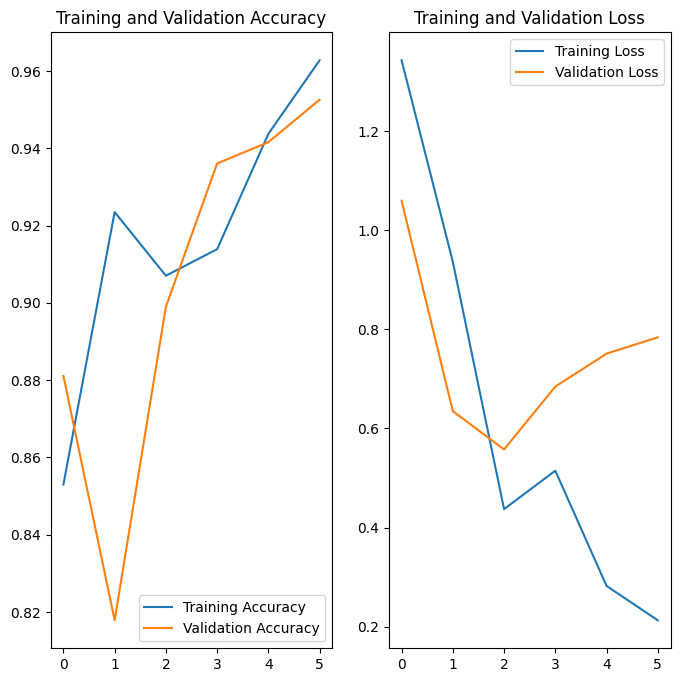

718/718 [==============================] - 2s 2ms/step


/tmp/ipykernel_1178480/502210451.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontdict={"fontsize":15}, rotation = 45)
/tmp/ipykernel_1178480/502210451.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, fontdict={"fontsize":15})


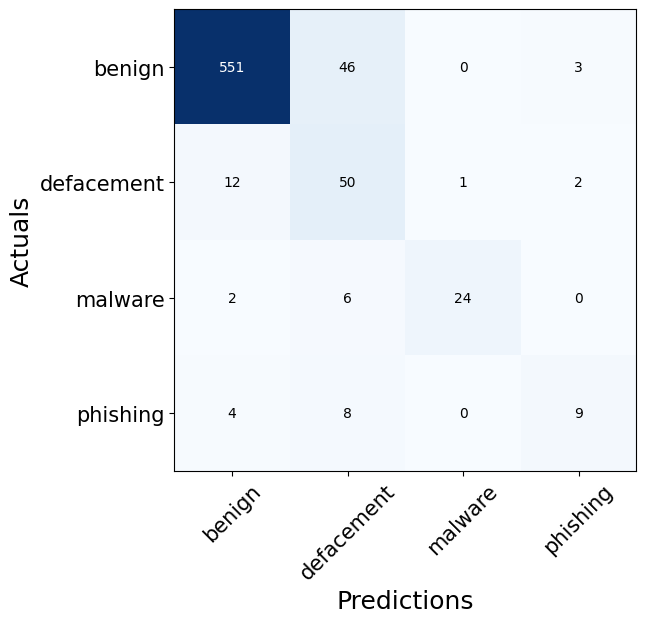

718/718 [==============================] - 1s 2ms/step


,url,actual,predicted
0,http://larcadelcarnevale.com/catalogo/palloncini,benign,benign
2,http://interpark.com/displaycorner/FreeMarket....,defacement,defacement
3,http://www.pn-wuppertal.de/links/2-linkseite/5...,benign,benign
4,http://www.parafiapiaski.pl/index.php?option=c...,benign,benign
5,http://fanpage.gr/family/gineka/%ce%b1%cf%85%c...,benign,benign
...,...,...,...
711,democraticspace.com/canada2008/ontario/,benign,benign
712,local.yahoo.com/info-18611978-assurant-employe...,phishing,phishing
715,igougo.com/attractions-reviews-b56475-Montreal...,benign,benign
716,thenudestar.com/Angela-Summers.html,benign,benign


,url,actual,predicted
1,https://docs.google.com/spreadsheet/viewform?f...,benign,defacement
10,http://9779.info/%E6%A0%91%E5%8F%B6%E7%B2%98%E...,benign,defacement
18,http://www.steffen-lemme.de/contact/berliner-b...,benign,defacement
24,http://9779.info/%E5%B9%BC%E5%84%BF%E7%B2%BD%E...,benign,defacement
43,http://torrentdn.com/bbs/s.php?bo_table=torren...,benign,defacement
...,...,...,...
696,http://www.selbsthilfegruppen.at/index.php?vie...,defacement,benign
699,visitlittletokyo.com/,benign,phishing
710,weberstatesports.com/ViewArticle.dbml?DB_OEM_I...,benign,defacement
713,fbschedules.com/ncaa-11/big-12/2011-missouri-t...,benign,defacement


In [26]:
for m in models:
    features_names_subset = m["features_names_subset"]
    model = m["model"]
    histories = m["histories"]
    test = m["test"]
    plot_epochs_vs_accuracy_and_loss(model, histories)
    show_confusion_matrix(model, test)
    show_prediction_vs_actual_dataframe_table(model, test)

## Predict More (Test) Data

In [27]:
def predict(url):
    one = download_one(url)
    if(one is None or ("status_code" in one and one["status_code"] != 200) or not any([feature_name in one for feature_name in feature_names])):
        return "Failed to get data for '" + url + "'"
    one = pd.DataFrame([one.values()], columns=list(one))
    one["redirects"] = one["redirects"].astype(str)
    one["latitude"] = one["latitude"].astype(str)
    one["longitude"] = one["longitude"].astype(str)
    
    tfds = tf.data.Dataset.from_tensor_slices(one[feature_names])
    
    outputs = []
    for m in models:
        features_names_subset = m["features_names_subset"]
        model = m["model"]
        histories = m["histories"]
        #outputs.append(", ".join(features_names_subset)+": "+one_hot_encoding_to_type_string(model.predict(tfds.map(genx)), test))
        outputs.append(one_hot_encoding_to_type_string(model.predict(tfds.map(genx), verbose=None), test))
    return "\n".join(outputs)

### Test URLs not in dataset

In [28]:
print(predict("https://cnn.com/"))
print(predict("https://google.com/"))
print(predict("https://disneyplus.com/"))
print(predict("https://uvm.edu/"))
print(predict("https://en.wikipedia.org/"))

benign
benign
benign
benign
benign


In [29]:
print(predict("http://www.tnekpvf.beauty/Toland-demythologize/de64h2395pM86H12C234b6R72e2M17VFEGsvtwfDm-mEGsi8mRj9mKQS7ro10nmV5h1ycY"))
print(predict("http://www.ultrabeautysurvey.live/l/lt60X31333KF1989H/2179UH9477P14712TK588WP589015417T401276368"))
print(predict("http://www.medicinalgardenkit.services/l/lt15M31326P2394WE/2582K11295E18557G588W589015417O1210863046"))

defacement
defacement
defacement
